# 1. Prepare data

res = (420, 236), n_data = 99120
data.shape = torch.Size([1, 99120])
uv.shape = torch.Size([1, 99120])


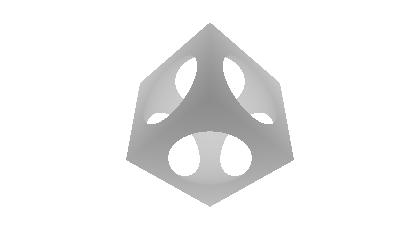

In [20]:
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np

data_img = Image.open("./test_small.png")
res = data_img.size
n_data = res[0] * res[1]
print(f"res = {res}, n_data = {n_data}")

# data = torch.reshape(
#     torch.transpose(
#         transforms.ToTensor()(data_img)[0], 0, 1),
#         (res[0] * res[1], 1))
data_img_tensor = transforms.ToTensor()(data_img)[0]

data = torch.reshape(
        data_img_tensor,
        (1, n_data))

print(f"data.shape = {data.shape}")

# uv = np.mgrid[0:res[0]:1, 0:res[1]:1].reshape(2,-1).T
# uv = torch.Tensor(uv).to(torch.long)
# print(uv.shape)

uv = torch.reshape(
    torch.Tensor(np.array(range(0, res[0]*res[1]))),
    (1, n_data))

print(f"uv.shape = {uv.shape}")

transforms.ToPILImage()(data_img_tensor)

# 2. Train MLP
### (However, the input to this MLP is too high dimensional to use in practice. )

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class sdf_net(nn.Module):
    def __init__(self):
        super(sdf_net, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_data, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, n_data)
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x 

model = sdf_net().to(device)
loss_fn = nn.MSELoss(reduction='mean')
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
uv = uv.to(device)
data =data.to(device)

def train(model, loss_fn, optimizer):

    pred = model(uv)
    loss = loss_fn(pred, data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

max_iter = 2000
loss_list = []

for t in range(max_iter):
    loss = train(model, loss_fn, optimizer)
    loss_list.append(loss)
    if t % 100 == 0:
        print(f"{t}: {loss}")

Using cuda device
0: 97363408.0
100: 0.9072569608688354
200: 0.7668789625167847
300: 0.5882812142372131
400: 0.410473495721817
500: 0.2631271779537201
600: 0.15736378729343414
700: 0.08921145647764206
800: 0.04897666722536087
900: 0.026280628517270088
1000: 0.013861480168998241
1100: 0.007254402618855238
1200: 0.0037295781075954437
1300: 0.001905928598716855
1400: 0.0009581963531672955
1500: 0.00047260726569220424
1600: 0.00023030520242173225
1700: 0.00011021804675692692
1800: 5.063528806203976e-05
1900: 2.2939326299820095e-05


In [22]:
fit = model(uv).cpu().detach()
print(fit)

(fit - data.cpu().detach()).norm()

tensor([[0.9997, 0.9999, 1.0009,  ..., 1.0002, 1.0004, 1.0001]])


tensor(1.0222)

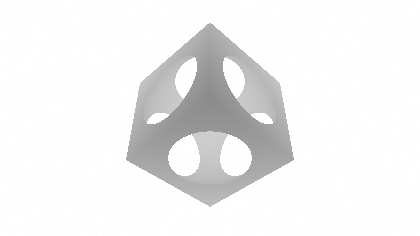

In [23]:
fit = torch.reshape(
    fit,
    (res[1], res[0])
)

fit_to_pil_img = transforms.ToPILImage()(fit)
fit_to_pil_img